In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import layers

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [2]:
SEED_VALUE = 42
# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

Dataset Exploration

In [3]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

print(X_train.shape)
print("\n")
print("Input features: ", X_train[0])
print("\n")
print("Output target: ", y_train[0])

(404, 13)


Input features:  [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


Output target:  15.2


In [4]:
boston_features = {
    "Average Number of Rooms": 5,
}

X_train_1d = X_train[:, boston_features["Average Number of Rooms"]]
print(X_train_1d.shape)

X_test_1d = X_test[:, boston_features["Average Number of Rooms"]]


(404,)


Extract Features from the Dataset

In [5]:
boston_features = {
    "Average Number of Rooms": 5,
}



X_train_1d = X_train[:, boston_features["Average Number of Rooms"]]

# This line extracts the column corresponding to
# "Average Number of Rooms" 
# (which is the 6th column, index 5) from the
# X_train dataset.

print(X_train_1d.shape)

X_test_1d = X_test[:, boston_features["Average Number of Rooms"]]

# Similarly, this line extracts the same column from
# the X_test dataset and stores it in X_test_1d.

print(X_test_1d.shape)


(404,)
(102,)


In [6]:
X_train_1d[:2]

array([6.142, 7.61 ])

In [7]:
X_test_1d[:2]

array([6.434, 5.913])

Plot the Features

In [8]:
# Here we plot the
# median price of
# a home vs. the single feature ('Average Number of Rooms').

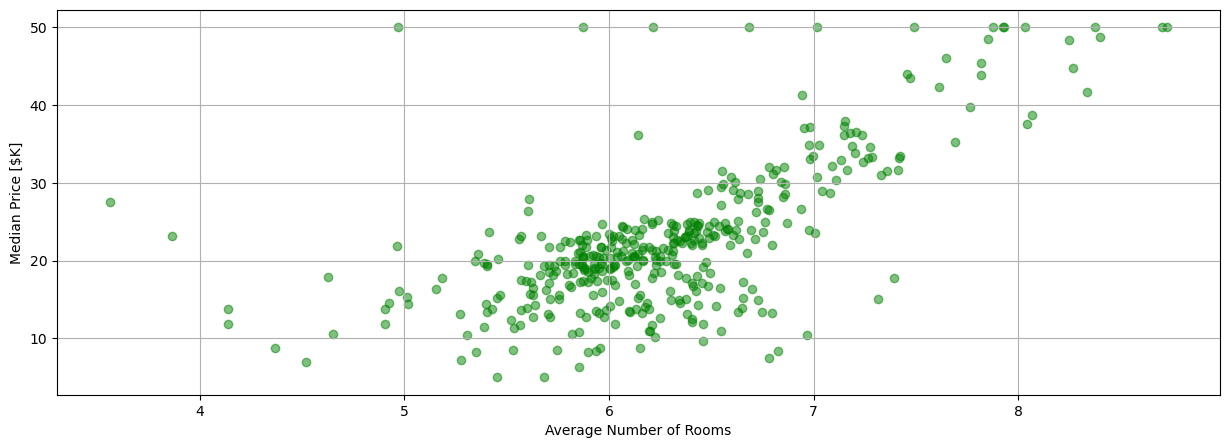

In [9]:
plt.figure(figsize=(15, 5))

plt.xlabel("Average Number of Rooms")
plt.ylabel("Median Price [$K]")
plt.grid("on")

plt.scatter(X_train_1d[:], y_train, color="green", alpha=0.5)


In [10]:
X_train_1d.min()


3.561

In [11]:
X_train_1d.mean()

6.267081683168317

In [12]:
X_train_1d.max()

8.725

In [13]:
y_train.min()

5.0

In [14]:
y_train.mean()

22.395049504950492

In [15]:
y_train.max()

50.0

In [16]:
y_train[y_train>45]

array([50. , 50. , 48.5, 50. , 46. , 50. , 50. , 48.8, 48.3, 45.4, 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. ])

### Data Preprocessing

In [17]:
import pandas as pd

In [18]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(102,)

In [20]:
X = df.feature_5.values
X.shape

(506,)

In [21]:
y = df.target
y.shape

(506,)

In [25]:
# Combine the datasets
X = pd.DataFrame(X_train.tolist() + X_test.tolist(), columns=[f'feature_{i}' for i in range(X_train.shape[1])])
y = pd.Series(y_train.tolist() + y_test.tolist(), name='target')

# Create a new DataFrame with feature_5 and target
df_new = pd.DataFrame({
    'feature_5': X.iloc[:, 5],
    'target': y
})
df_new

,feature_5,target
0,6.142,15.2
1,7.610,42.3
2,4.970,50.0
3,6.037,21.1
4,6.376,17.7
...,...,...
501,8.780,21.9
502,6.273,24.1
503,7.802,50.0
504,6.951,26.7


In [27]:
# Calculate Q1 and Q3
Q1 = df_new['feature_5'].quantile(0.25)
Q3 = df_new['feature_5'].quantile(0.75)
IQR = Q3 - Q1

# Determine the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df_new[(df['feature_5'] >= lower_bound) & (df_new['feature_5'] <= upper_bound)]
df_filtered

,feature_5,target
0,6.142,15.2
1,7.610,42.3
2,4.970,50.0
3,6.037,21.1
4,6.376,17.7
...,...,...
499,6.122,21.5
500,7.333,36.0
502,6.273,24.1
504,6.951,26.7


In [31]:
df_filtered = df_filtered[df_filtered['target']<40]
df_filtered = df_filtered[(df_filtered['feature_5']<7.3)&(df_filtered['feature_5']>5)]

df_filtered

,feature_5,target
0,6.142,15.2
3,6.037,21.1
4,6.376,17.7
5,5.708,18.5
6,5.536,11.3
...,...,...
498,6.812,35.1
499,6.122,21.5
502,6.273,24.1
504,6.951,26.7


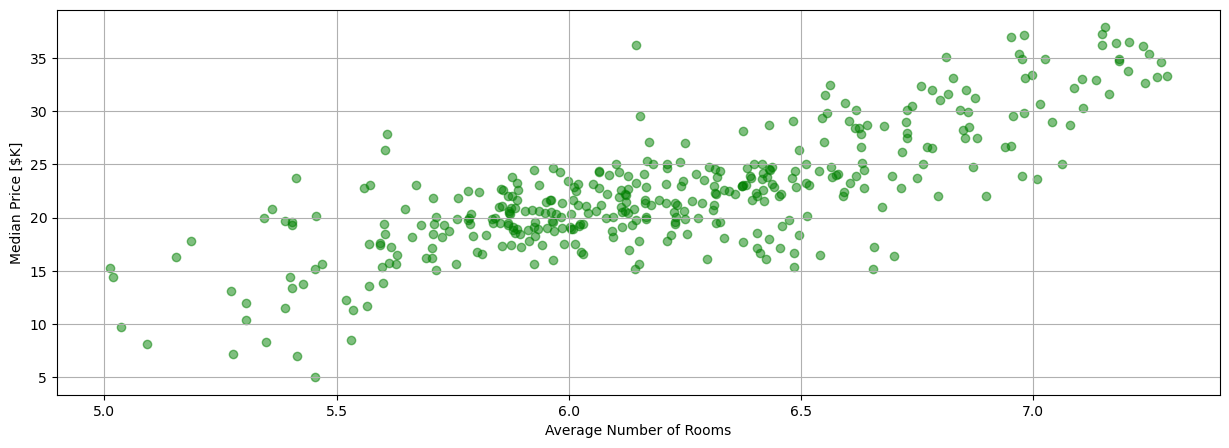

In [71]:
plt.figure(figsize=(15, 5))

plt.xlabel("Average Number of Rooms")
plt.ylabel("Median Price [$K]")
plt.grid("on")

plt.scatter(df_filtered['feature_5'], df_filtered['target'], color="green", alpha=0.5)


In [70]:
# Define the ranges to remove
y_min, y_max = 5, 15
x_min, x_max = 5.6, 7

# Filter out the points within the specified ranges
df_filtered = df_filtered[~((df_filtered['target'] >= y_min) & (df_filtered['target'] <= y_max) & 
                   (df_filtered['feature_5'] >= x_min) & (df_filtered['feature_5'] <= x_max))]


### Model

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_filtered['feature_5'], df_filtered['target'])

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()

# Input layer
model.add(Dense(units=30, input_shape=(1,), activation='relu'))
# Hidden layers
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=10, activation='relu'))

# Output layer
model.add(Dense(units=1))

model.compile(optimizer= SGD(learning_rate=0.001), loss="mae")
history = model.fit(
    X_train, 
    y_train, 
    batch_size=16, 
    epochs=100, 
    validation_split=0.2,
    verbose=''
)
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
print(f"R² score: {r2}")


3/3 [==============================] - 0s 4ms/step
R² score: 0.3995806519665712


In [74]:
from sklearn.linear_model import LinearRegression
# Reshape the data if necessary
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
print(f"R² score: {r2}")

R² score: 0.7096395964766409


In [75]:
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)
# Predict and evaluate the model
y_test_pred = model.predict(X_test_poly)
r2 = r2_score(y_test, y_test_pred)
print(f"R² score: {r2}")

R² score: 0.6877714357314024


In [44]:
model = Sequential()

# Input layer with 64 neurons
model.add(Dense(units=1, input_shape=(1,)))
# Hidden layers with varying neurons and dropout
model.add(Dense(units=10, activation='selu'))
model.add(Dense(units=10, activation='selu'))

# Output layer with a single neuron and no activation function (linear)
model.add(Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss="mae")
history = model.fit(
    X_train, 
    y_train, 
    batch_size=16, 
    epochs=101, 
    verbose='',
    validation_split=0.2,
)

In [45]:
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
print(f"R² score: {r2}")


4/4 [==============================] - 0s 3ms/step
R² score: 0.04440741999831144


Linear Regression Model

Define the Keras Model

In [ ]:
model = Sequential()

# Input layer with 64 neurons
model.add(Dense(units=1, input_shape=(1,)))
# Hidden layers with varying neurons and dropout
model.add(Dense(units=10, activation='selu'))
model.add(Dense(units=10, activation='selu'))
# Output layer with a single neuron and no activation function (linear)
model.add(Dense(units=1))

# Display a summary of the model architecture.
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 1)                 2         
                                                                 
 dense_99 (Dense)            (None, 10)                20        
                                                                 
 dense_100 (Dense)           (None, 60)                660       
                                                                 
 dense_101 (Dense)           (None, 50)                3050      
                                                                 
 dense_102 (Dense)           (None, 50)                2550      
                                                                 
 dense_103 (Dense)           (None, 50)                2550      
                                                                 
 dense_104 (Dense)           (None, 50)              

Compile the Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss="mae")

Train the Model

In [ ]:
history = model.fit(
    X_train_1d, 
    y_train, 
    batch_size=16, 
    epochs=101, 
    verbose='',
    validation_split=0.2,
)

model evaluation

In [ ]:
y_test_pred = model.predict(X_test_1d)
r2 = r2_score(y_test, y_test_pred)
print(f"R² score: {r2}")


4/4 [==============================] - 0s 2ms/step
R² score: 0.48781401598959295


Plot the Training Results

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], 'g', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    plt.xlim([0, 100])
    plt.ylim([0, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

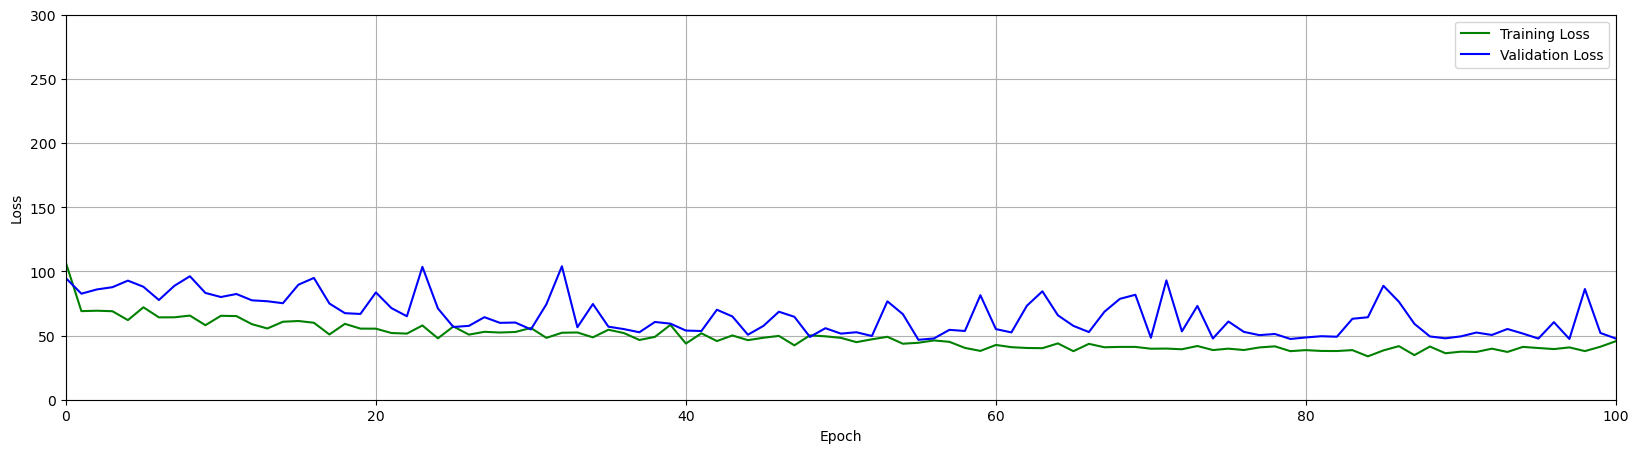

In [ ]:
plot_loss(history)

Make Predictions using the Model

In [ ]:
# Predict the median price of a home with [3, 4, 5, 6, 7] rooms.
x = [3, 4, 5, 6, 7]
y_pred = model.predict(x)
for idx in range(len(x)):
    print(f"Predicted price of a home with {x[idx]} rooms: ${int(y_pred[idx] * 10) / 10}K")

1/1 [==============================] - 0s 139ms/step
Predicted price of a home with 3 rooms: $16.9K
Predicted price of a home with 4 rooms: $16.2K
Predicted price of a home with 5 rooms: $15.7K
Predicted price of a home with 6 rooms: $18.1K
Predicted price of a home with 7 rooms: $29.6K


Plot the Model and the Data

In [ ]:
# Generate feature data that spans the range of interest for the independent variable.
x = np.linspace(3, 9, 10)

# Use the model to predict the dependent variable.
y = model.predict(x)

1/1 [==============================] - 0s 54ms/step


In [ ]:
def plot_data(x_data, y_data, x, y, title=None):
    
    plt.figure(figsize=(15,5))
    plt.scatter(x_data, y_data, label='Ground Truth', color='green', alpha=0.5)
    plt.plot(x, y, color='k', label='Model Predictions')
    plt.xlim([3,9])
    plt.ylim([0,60])
    plt.xlabel('Average Number of Rooms')
    plt.ylabel('Price [$K]')
    plt.title(title)
    plt.grid(True)
    plt.legend()

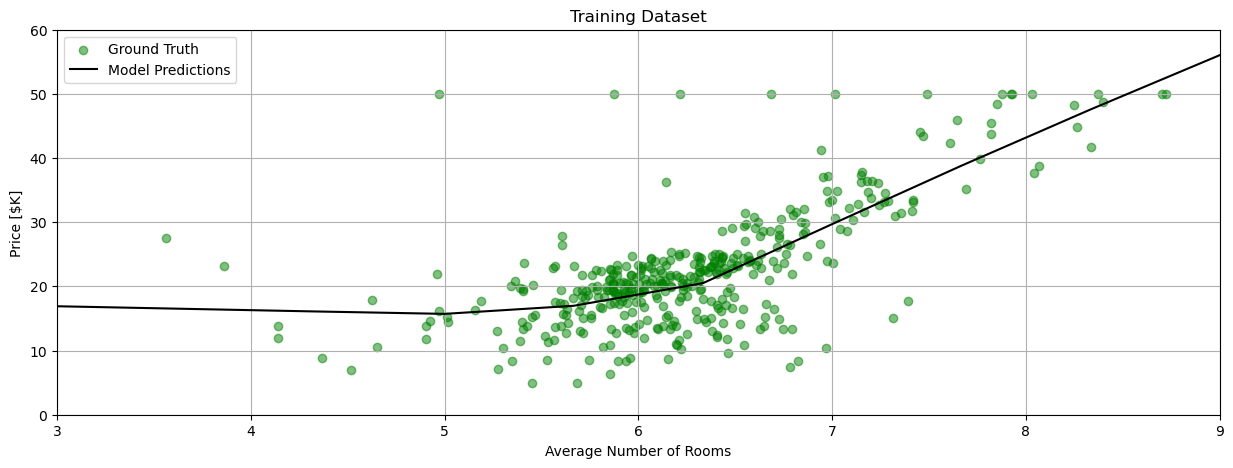

In [ ]:
plot_data(X_train_1d, y_train, x, y, title='Training Dataset')


## Intro to linear Regression 

In [102]:
import pandas as pd
import numpy as np

# Generate 50 random X values between 0 and 10
X = np.random.uniform(0, 20, size=50)

# Generate Y values based on a linear relationship with noise
slope = 2
intercept = 3
noise = np.random.normal(0, 1, size=50)
Y = slope * X + intercept + noise

# Create a DataFrame with X and Y columns
data = pd.DataFrame({'X': X, 'Y': Y})



In [103]:
data.head()

,X,Y
0,6.922933,17.358851
1,15.661395,34.284024
2,11.252751,26.407674
3,8.145286,18.621975
4,17.528047,37.347423


In [104]:
import matplotlib.pyplot as plt

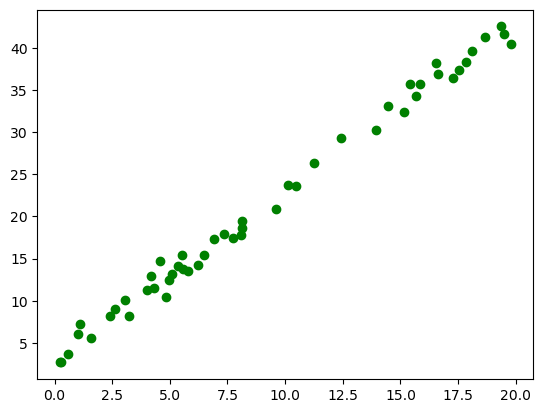

In [105]:
plt.scatter(X, Y, color = 'g')

## EDA

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       50 non-null     float64
 1   Y       50 non-null     float64
dtypes: float64(2)
memory usage: 932.0 bytes


In [107]:
data.describe()

,X,Y
count,50.000000,50.000000
mean,9.096541,21.263005
std,6.158284,12.400203
min,0.238241,2.664977
25%,4.385784,11.699568
50%,7.530161,17.625096
75%,15.350167,33.997929
max,19.789450,42.561472


In [108]:
data.shape

(50, 2)

## Train Test Split

In [109]:
y = data['Y']
y.shape

(50,)

In [110]:
X = data['X']
X.shape

(50,)

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
xtrain , xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
print('x train shape', xtrain.shape)
print('x test shape', xtest.shape)
print('y train shape', ytrain.shape)
print('y test shape', ytest.shape)

x train shape (40,)
x test shape (10,)
y train shape (40,)
y test shape (10,)


## Model

In [114]:
from sklearn.linear_model import LinearRegression

In [115]:
model = LinearRegression()


In [116]:
model.fit(xtrain, ytrain)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [117]:

xtrain = xtrain.values.reshape(-1, 1)  # Reshape to 2D
ytrain = ytrain.values  # This should remain 1D

In [118]:
model.fit(xtrain, ytrain)

LinearRegression()

In [119]:
model.coef_

array([2.00835718])

In [120]:
model.intercept_

3.062168819904901

In [121]:
from sklearn.metrics import r2_score

In [122]:
xtest = xtest.values.reshape(-1, 1)  # Ensure xtest is 2D

In [123]:
y_pred = model.predict(xtest)

In [124]:
accuracy = r2_score(ytest, y_pred)
accuracy

0.9938101459041003

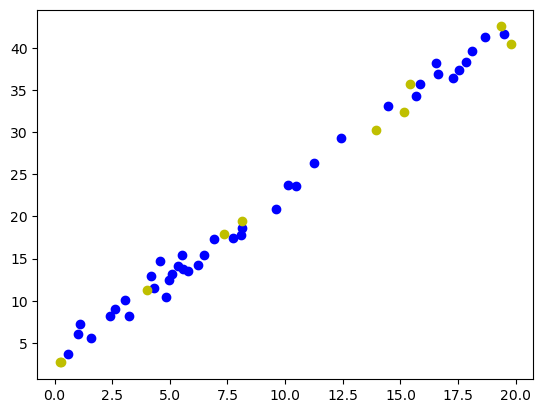

In [125]:
plt.scatter(xtrain, ytrain, c='b')
plt.scatter(xtest, ytest, c='y')

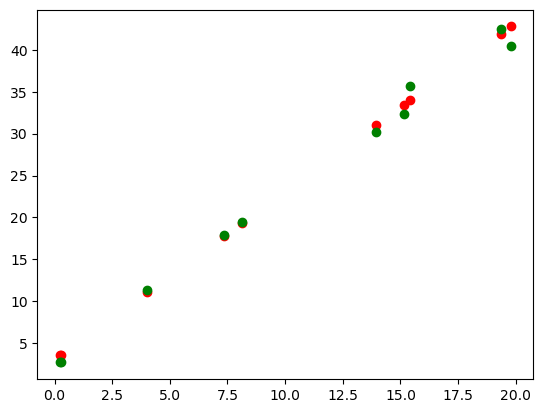

In [126]:
plt.scatter(xtest, y_pred, c='r')
plt.scatter(xtest, ytest, c='g')

## mean absolute error

In [127]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, y_pred)


0.8679080044407202

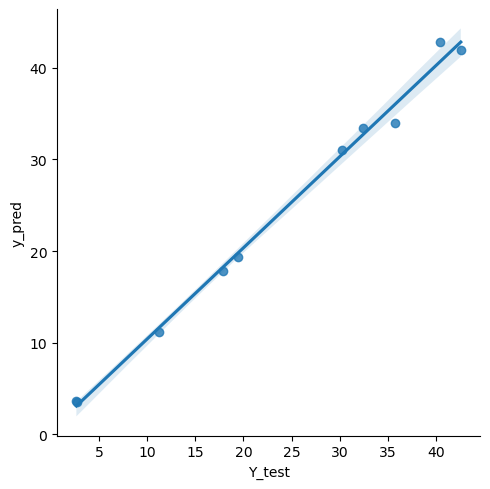

In [132]:
import seaborn as sns

df = pd.DataFrame({
    'Y_test': Y_test,
    'y_pred': y_pred
})
sns.lmplot(x='Y_test', y='y_pred', data=df)



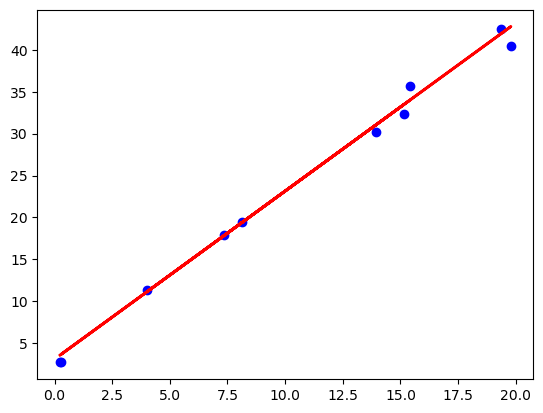

In [134]:

# Plot the actual data
plt.scatter(xtest, ytest, color='blue')

# Plot the predicted data
plt.plot(xtest, y_pred, color='red', linewidth=2)

plt.show()

## Clean version of the above code

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [58]:
# Generate example data
data = pd.DataFrame({
    'X': np.random.uniform(0, 10, size=50),
    'Y': 2 * np.random.uniform(0, 10, size=50) + 3 + np.random.normal(0, 1, size=50)
})

In [59]:
# Split the data into training and testing sets
X = data['X'].values.reshape(-1, 1)
y = data['Y'].values
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
# Initialize the model
model = LinearRegression()


In [61]:
# List to store loss values
losses = []

In [62]:
# Fit the model and track the loss
for epoch in range(100):  # Example of multiple epochs
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtrain)
    loss = mean_squared_error(ytrain, y_pred)
    losses.append(loss)

In [63]:
# Make predictions on the test set
y_pred_test = model.predict(xtest)


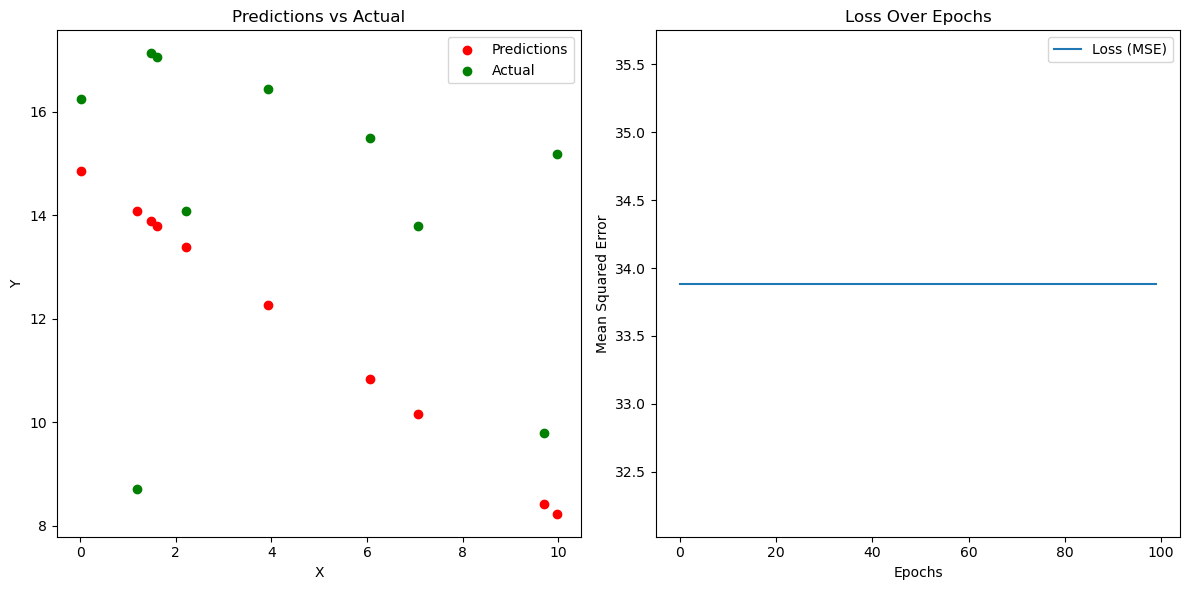

In [64]:

# Plotting the results
plt.figure(figsize=(12, 6))

# Scatter plot for predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(xtest, y_pred_test, c='r', label='Predictions')
plt.scatter(xtest, ytest, c='g', label='Actual')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predictions vs Actual')
plt.legend()

# Plotting the loss values
plt.subplot(1, 2, 2)
plt.plot(losses, label='Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Do the same using Tensorflow Framework

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [94]:
# Generate example data
data = pd.DataFrame({
    'X': np.random.uniform(0, 10, size=50),
    'Y': 2 * np.random.uniform(0, 10, size=50) + 3 + np.random.normal(0, 1, size=50)
})

In [95]:
# Split the data into training and testing sets
X = data['X'].values.reshape(-1, 1)  # Reshape to 2D
y = data['Y'].values  # This should remain 1D
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape =(1,))
])

In [97]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [98]:
# Train the model and store the history
history = model.fit(xtrain, ytrain, epochs=100, verbose=0)

In [99]:
# Make predictions on the test set
y_pred = model.predict(xtest)

1/1 [==============================] - 0s 81ms/step


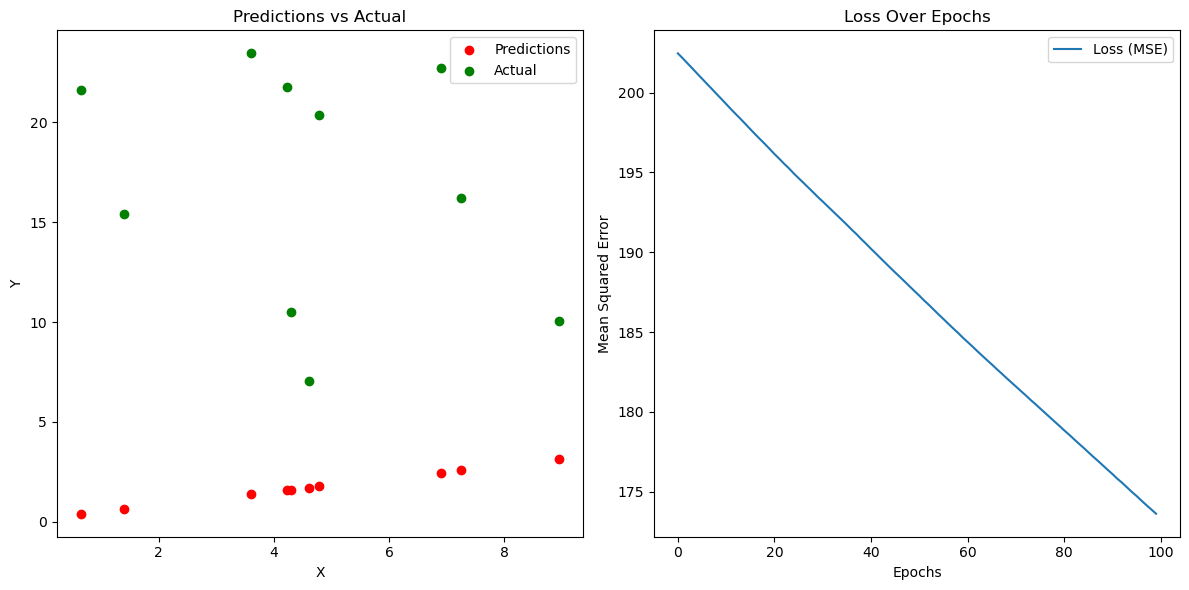

In [100]:

# Plotting the results
plt.figure(figsize=(12, 6))

# Scatter plot for predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(xtest, y_pred, c='r', label='Predictions')
plt.scatter(xtest, ytest, c='g', label='Actual')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predictions vs Actual')
plt.legend()

# Plotting the loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
r2_score